# Measurement errors in both dependent and independent variables

Regression defined as the relation between a dependent variable, $\eta_i$, and a set of independent 
variables, $\xi_i$, that describes the expectation value of $\eta_i$ given $\xi_i$. 
There may be intrinsic scatter, $\epsilon_i$, too.

In most cases, however, what we observe are values $x_i$ and $y_i$ and 
associated measurement errors, $\epsilon_{x,i}$ and $\epsilon_{y,i}$. 
Following [Kelly 2007](https://iopscience.iop.org/article/10.1086/519947/pdf), 
we can write the regression relationship as:

$$ \eta_i = \alpha + \beta \xi_i + \epsilon_i $$ and 
$$ x_i = \xi_i + \epsilon_{x,i}$$
$$y_i = \eta_i + \epsilon_{y,i}$$

## Data sets used in the examples below

Use simulation data from [Kelly 2007](https://iopscience.iop.org/article/10.1086/519947/pdf). 
This simulator, called `simulation_kelly`  is available from `astroML.datasets`.

The function returns the $\xi_i$, $\eta_i$, $x_i$, $y_i$, $\epsilon_{x,i}$, $\epsilon_{y,i}$ and 
the input regression coefficients $\alpha$ and $\beta$ and intrinsic scatter $\epsilon$. 
A total of ``size`` values generated, measurement errors are scaled by parameters ``scalex`` and
 ``scaley`` following secion 7.1 in [Kelly 2007](https://iopscience.iop.org/article/10.1086/519947/pdf).

In [1]:
from astroML.datasets import simulation_kelly

ksi, eta, xi, yi, xi_error, yi_error, alpha_in, beta_in = simulation_kelly(size=100, scalex=0.2, scaley=0.2,
                                                                           alpha=2, beta=1, epsilon=(0, 0.75))

### Plot the generated data

Plot both the simulated $\xi$, $\eta$ dataset as well the generated observed values of $x_i$ and $y_i$ 
including their measurement errors for different values of the scale parameters ``scalex`` and ``scaley``.

In [2]:
#%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from astroML.plotting import setup_text_plots
setup_text_plots()

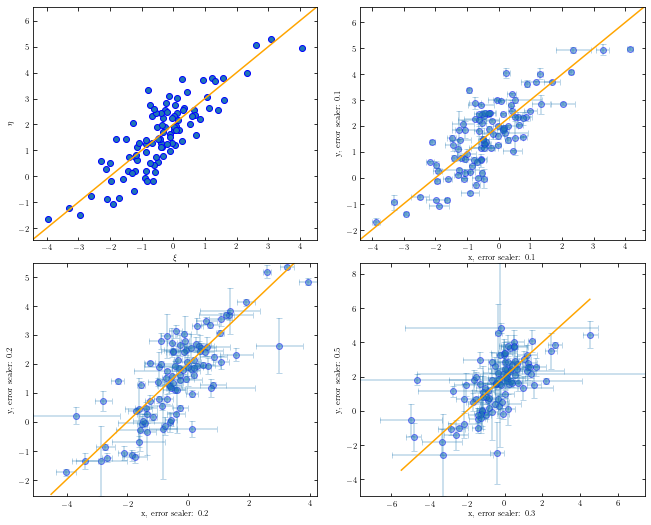

In [3]:
ksi_0 = np.arange(np.min(ksi) - 0.5, np.max(ksi) + 0.5)
eta_0 = alpha_in + ksi_0 * beta_in

figure = plt.figure(figsize=(10, 8))
figure.subplots_adjust(left=0.1, right=0.95,
                       bottom=0.1, top=0.95,
                       hspace=0.1, wspace=0.15)
ax = figure.add_subplot(221)
ax.scatter(ksi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')

ax.plot(ksi_0, eta_0, color='orange')

for scalex, scaley, axn in [(0.1, 0.1, 222), (0.3, 0.5, 224), (0.2, 0.2, 223)]:
    _, _, xi, yi, xi_error, yi_error, _, _ = simulation_kelly(size=100, scalex=scalex, scaley=scaley,
                                                              alpha=alpha_in, beta=beta_in, ksi=ksi, eta=eta)    
    ax = figure.add_subplot(axn)

    ax.scatter(xi[0], yi, alpha=0.5)
    ax.errorbar(xi[0], yi, xerr=xi_error[0], yerr=yi_error, alpha=0.3, ls='')
    ax.set_xlabel(f'x, error scaler: {scalex}')
    ax.set_ylabel(f'y, error scaler: {scaley}')

    x0 = np.arange(np.min(xi) - 0.5, np.max(xi) + 0.5)
    y0 = alpha_in + x0 * beta_in
    ax.plot(x0, y0, color='orange')

plt.savefig('regression_input_data.pdf')    

### Linear regression with uncertainties in both dependent and independent axes
 
The class ``LinearRegressionwithErrors`` can be used to take into account measurement errors in 
both the dependent and independent variables. 
The implementation relies on the [PyMC3](https://docs.pymc.io/) and [Theano](http://deeplearning.net/software/theano/)
packages. 

Note: The first initialization of the fitter is expected to take a couple of minutes, as ``Theano`` 
performs some code compilation for the underlying model. Sampling for consecutive runs is expected
to start up significantly faster.
 


In [4]:
from astroML.linear_model import LinearRegressionwithErrors

In [5]:
linreg_xy_err = LinearRegressionwithErrors()
linreg_xy_err.fit(xi, yi, yi_error, xi_error)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ksi, mu, tau, int_std, inter, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


LinearRegressionwithErrors()

## Plot the results



In [6]:
from astroML.plotting import plot_regressions, plot_regression_from_trace

Optimization terminated successfully.
         Current function value: 92.757710
         Iterations: 29
         Function evaluations: 56
beta: 0.9897231165381162 alpha: 1.8929633510539032


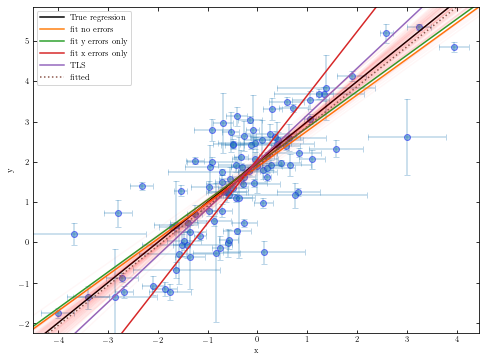

In [7]:
plot_regressions(ksi, eta, xi[0], yi, xi_error[0], yi_error, add_regression_lines=True, alpha_in=alpha_in, beta_in=beta_in)
plot_regression_from_trace(linreg_xy_err, (xi, yi, xi_error, yi_error), ax=plt.gca(), chains=50)


plt.savefig('regression_compare_regressions.pdf')

## Multivariate regression
For multivariate data (where we fit a hyperplane rather than a straight line) we simply extend the description
of the regression function to multiple dimensions. The formalism used in the previous example becomes:


$$ \eta_i = \alpha + \beta^T \xi_i + \epsilon_i $$ 

where both $\beta^T$ and $\xi_i$ are now N-element vectors.

### Generate a dataset:

We use the same function as above to generate 100 datapoints in 2 dimensions. Note that the size of the ``beta`` 
parameter needs to match the dimensions.

In [8]:
ksi2, eta2, xi2, yi2, xi_error2, yi_error2, alpha_in2, beta_in2 = simulation_kelly(size=100, scalex=0.2, scaley=0.2,
                                                                                   alpha=2, beta=[0.5, 1],
                                                                                   multidim=2)

The previously used ``LinearRegressionwithErrors`` class can be used with multidimensional data, thus the fitting is done the exact same way as before:

In [9]:
linreg_xy_err2 = LinearRegressionwithErrors()
linreg_xy_err2.fit(xi2, yi2, yi_error2, xi_error2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ksi, mu, tau, int_std, inter, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


LinearRegressionwithErrors()

There are several ways to explore the fits, in the following we show a few ways to plot this dataset. As in this example the fitted hyperplane was 2D, we can use a 3D plot to show both the fit and the underlying regession we used to generate the data from. In this 3D plot, the blue plane is the true regression, while the red plane is our fit, that takes into account the errors on the data points.

Other plotting libraries can also be used to e.g. create pairplots of the parameters (e.g. Arviz' ``plot_pair`` function, or Seaborn's ``jointplot``).

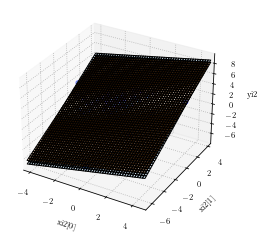

In [10]:
x0 = np.linspace(np.min(xi2[0])-0.5, np.max(xi2[0])+0.5, 50)
x1 = np.linspace(np.min(xi2[1])-0.5, np.max(xi2[1])+0.5, 50)
x0, x1 = np.meshgrid(x0, x1)

y0 = alpha_in + x0 * beta_in2[0] + x1 * beta_in2[1]

y_fitted = linreg_xy_err2.coef_[0] + x0 * linreg_xy_err2.coef_[1] + x1 * linreg_xy_err2.coef_[2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('xi2[0] ')
ax.set_ylabel('xi2[1] ')
ax.set_zlabel('yi2 ')
ax.scatter(xi2[0], xi2[1], yi2, s=20)
ax.plot_surface(x0, x1, y0, alpha=0.2, facecolor='blue', label='True regression')
ax.plot_surface(x0, x1, y_fitted, alpha=0.2, facecolor='red', label='Fitted regression')



plt.savefig('regression_multivariate.pdf')

### Sampler statistics and traceplots

The PyMC3 trace is available in the ``.trace`` attribute of the class instances (e.g. ``linreg_xy_err2.trace`` in the previous example), after we performed the fit. This can be then used for checking for convergence, and generating statistics for the samples. We would refer to use the tools provided by PyMC3, e.g. the ``traceplot()`` that takes the trace object as its input. Note that in the multidimensional case, there will be multiple ``ksi`` and ``slope`` traces in aggreement with the dimensionality of the input ``xi`` data, in the ``traceplot`` they are plotted with different colours. 

/Users/bsipocz/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


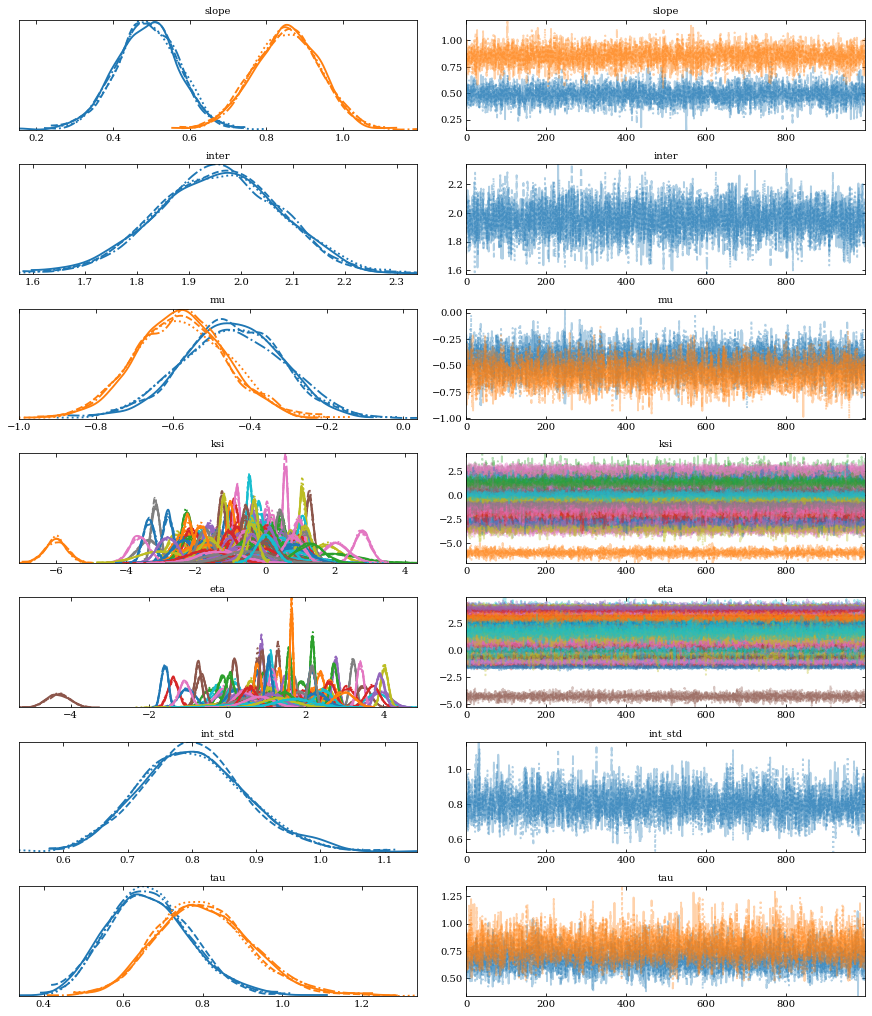

In [12]:
import pymc3 as pm
matplotlib.rc('text', usetex=False)

pm.traceplot(linreg_xy_err2.trace)

plt.savefig('regression_tracefig.pdf')